# SPOT Glucose Predictions

By Garrett Roell and Christina Schenk

Tested on biodesign_3.7 kernel on jprime

This notebook performs SPOT calculations for R. opacus in glucose and creates plots to compare the results with experimental data.                                               
### Method: 
<ol>
<li>Set up imports</li>
<li>Load model and relevant data</li>
<li>Calculate glucose SPOT solutions</li>
<li>Compare glucose SPOT flux predictions with 13C-MFA fluxes</li>
<li>Generate glucose SPOT flux map</li>
<li>Add SPOT glucose data to growth parameters data</li>
</ol>


### 1. Set up imports

In [1]:
import cobra
import pandas as pd
import sys

source_dir = '../src'
sys.path.append(source_dir)

from utils import *
from cobra_functions import get_SPOT_solution
from plot import *

output_dir = '../plots/'

### 2. Load model and relevant data

In [2]:
model = cobra.io.read_sbml_model("../models/r_opacus_annotated_curated.xml")

# load transcript data for wildtype glucose
transcript_df = pd.read_csv('../data/transcript_data/henson_CPM_melted.csv')
transcript_df = transcript_df[transcript_df['Line Name'].str.contains("WT-Glu")]

# load 13C-MFA data
glucose_13C_fluxes = pd.read_csv('../data/central_fluxes/glucose_13C.csv')

# load experimental growth parameters
growth_parameters = pd.read_csv('../data/growth_parameters/experimental_growth_parameters.csv', index_col=0)

Isolate transcript data from the first time point

In [3]:
transcript_df_T1 = transcript_df[transcript_df['Time'] == 10]
transcript_df_T1.head()

,Line Name,Measurement Type,Time,Count,Units
6,WT-Glu-R1,WP_005263480_1,10,27.446117,CPM
7,WT-Glu-R2,WP_005263480_1,10,27.543845,CPM
8,WT-Glu-R3,WP_005263480_1,10,26.797758,CPM
60,WT-Glu-R1,WP_005249107_1,10,355.352526,CPM
61,WT-Glu-R2,WP_005249107_1,10,349.533393,CPM


Isolate transcript data from the second time point

In [4]:
transcript_df_T2 = transcript_df[transcript_df['Time'] == 13]
transcript_df_T2.head()

,Line Name,Measurement Type,Time,Count,Units
9,WT-Glu-R1,WP_005263480_1,13,15.584245,CPM
10,WT-Glu-R2,WP_005263480_1,13,22.444427,CPM
11,WT-Glu-R3,WP_005263480_1,13,20.433310,CPM
63,WT-Glu-R1,WP_005249107_1,13,219.798570,CPM
64,WT-Glu-R2,WP_005249107_1,13,328.518773,CPM


### 3. Calculate glucose SPOT solutions

In [5]:
%%time

# create dictionary to hold SPOT solutions
spot_solutions = {}

# loop over time points and trials
for time in ['T1', 'T2']:
    for trial in ['WT-Glu-R1', 'WT-Glu-R2','WT-Glu-R3']:
                
        # get trial name
        trial_number = trial.split('-R')[1]
        trial_name = f'glucose_spot_{time.lower()}_{trial_number}'
        print(trial_name)
        
        # isolate transcriptomics data from a single time point
        if time == 'T1':
            transcript_df = transcript_df_T1[transcript_df_T1['Line Name'] == trial]
        else:
            transcript_df = transcript_df_T2[transcript_df_T2['Line Name'] == trial]
            
        # remove unneeded columns
        transcript_df = transcript_df.filter(['Count', 'Measurement Type'])

        # set index of dataframe to be gene names
        transcript_df = transcript_df.set_index('Measurement Type')
        
        # run spot to get genome scale fluxes
        spot_solution = get_SPOT_solution(model, transcript_df, 'glucose', substrate_uptake_rate=100)
        
        # add spot solution to dictionary
        spot_solutions[trial_name] = spot_solution

glucose_spot_t1_1
-0.03903531860559422
-4.332720640837213e-12
-0.03903531860559422
0.0
glucose_spot_t1_2
-0.03777243806431751
-3.024786111824995e-12
-0.03777243806431751
0.0
glucose_spot_t1_3
-0.03886192166702561
-4.936960649545921e-12
-0.03886192166702561
0.0
glucose_spot_t2_1
-0.034131707859466905
-1.317343776819384e-11
-0.034131707859466905
0.0
glucose_spot_t2_2
-0.038311627309031
-2.930774598694265e-12
-0.038311627309031
0.0
glucose_spot_t2_3
-0.03281761863615189
-2.056057120662767e-12
-0.03281761863615189
0.0
CPU times: user 2min 51s, sys: 3.07 s, total: 2min 54s
Wall time: 2min 50s


Save glucose SPOT genome scale fluxes

In [6]:
# create a dictionary to hold genome scale flux solution dataframes
trial_solution_dfs = {}

# loop over solution dictionary. Convert the flux solutions to 
for trial_name, flux_solution in spot_solutions.items():

    # convert cobra solution to a dataframe
    flux_df = cobra_solution_to_df(model, flux_solution)
    
    # save the dataframe in a dictionary and as a csv
    trial_solution_dfs[trial_name] = flux_df
    flux_df.to_csv(f'../data/genome_scale_fluxes/{trial_name}.csv', index=False)

### 4. Compare glucose SPOT flux predictions with 13C-MFA fluxes

Copy 13C flux data and remove rows that do not have a mapping to the GSM

In [7]:
glucose_fluxes = glucose_13C_fluxes.copy()

# # Remove rows that do not have a mapping to the GSM
glucose_fluxes.dropna(subset = ["Reaction Ids"], inplace=True) 
print(f'There are {len(glucose_fluxes)} fluxes that can be compared between the MFA and SPOT')

glucose_fluxes.head()

There are 44 fluxes that can be compared between the MFA and SPOT


,Pathway,Reaction Ids,Reaction,Location on map,13C Flux,13C Lower Bound,13C Upper Bound
0,Substrate Uptake,reverse_EX_glc__D_e,Gluc.ext + ATP -> G6P,"(50, 460)",100.00,100.00,100.00
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-1.61,-2.09,1.42
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",0.00,0.00,1.91
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",0.00,0.00,1.91
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",0.00,0.00,1.91


Map each trial to 13C-MFA fluxes and add to dataframe of all trials

In [8]:
relevant_trials = [
    'glucose_spot_t1_1', 
    'glucose_spot_t1_2', 
    'glucose_spot_t1_3',
    'glucose_spot_t2_1', 
    'glucose_spot_t2_2', 
    'glucose_spot_t2_3'
]

all_trials_glucose_fluxes = glucose_fluxes.copy()

# define constants to use below
uptake_reaction = 'EX_glc__D_e'
normalized_uptake_rate = -100

# loop over trials
for trial in relevant_trials:

    # calculate the scale factor using the solution uptake rate and the normalized uptake rate
    scale_factor = normalized_uptake_rate / spot_solutions[trial].fluxes[uptake_reaction]

    # get the solution object from a dictionary created above
    solution = spot_solutions[trial]

    # add the solution fluxes to the 13C flux dataframe
    column_name = trial
    all_trials_glucose_fluxes = add_column_to_13C_flux_df(all_trials_glucose_fluxes, solution, column_name)
    
    # scale the solution fluxes in the dataframe by the scale factor
    all_trials_glucose_fluxes[column_name] = scale_factor * all_trials_glucose_fluxes[column_name]

all_trials_glucose_fluxes.head()

,Pathway,Reaction Ids,Reaction,Location on map,13C Flux,13C Lower Bound,13C Upper Bound,glucose_spot_t1_1,glucose_spot_t1_2,glucose_spot_t1_3,glucose_spot_t2_1,glucose_spot_t2_2,glucose_spot_t2_3
0,Substrate Uptake,reverse_EX_glc__D_e,Gluc.ext + ATP -> G6P,"(50, 460)",100.00,100.00,100.00,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-1.61,-2.09,1.42,59.057947,60.351455,74.205934,72.164432,45.579071,59.531088
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",0.00,0.00,1.91,43.974032,43.197569,59.074262,57.404852,30.754589,41.185711
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",0.00,0.00,1.91,43.974032,43.197569,59.074262,57.404852,30.754589,41.185711
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",0.00,0.00,1.91,26.285675,27.711623,33.514976,31.394391,17.980043,19.584676


Calculate the average and standard deviation of each flux prediction

In [9]:
# only use the first time point for SPOT analysis
relevant_trials = [
    'glucose_spot_t1_1', 
    'glucose_spot_t1_2', 
    'glucose_spot_t1_3',
#     'glucose_spot_t2_1', 
#     'glucose_spot_t2_2', 
#     'glucose_spot_t2_3'
]

# make lists to hold average and standard deviation values
average_flux_values = []
std_flux_values = []

# loop over each reaction in the all_trials_glucose_fluxes dataframe
for _, row in all_trials_glucose_fluxes.iterrows():
    
    # make a list of flux values for a given reaction
    flux_values = [row[trial] for trial in relevant_trials]
    
    # calculate average and add to a list
    average = sum(flux_values) / len(relevant_trials)
    average_flux_values.append(average)
    
    # calculate standard deviation and add to a list
    std = np.std(flux_values)
    std_flux_values.append(std)

# use the average and standard deviation lists to add columns to the 13C dataframe
glucose_fluxes['SPOT WT Flux'] = average_flux_values
glucose_fluxes['SPOT WT Flux Std'] = std_flux_values

glucose_fluxes.head()

,Pathway,Reaction Ids,Reaction,Location on map,13C Flux,13C Lower Bound,13C Upper Bound,SPOT WT Flux,SPOT WT Flux Std
0,Substrate Uptake,reverse_EX_glc__D_e,Gluc.ext + ATP -> G6P,"(50, 460)",100.00,100.00,100.00,100.000000,0.000000
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-1.61,-2.09,1.42,64.538445,6.856313
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",0.00,0.00,1.91,48.748621,7.308209
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",0.00,0.00,1.91,48.748621,7.308209
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",0.00,0.00,1.91,29.170758,3.126500


Save glucose SPOT central flux predictions

In [10]:
glucose_fluxes.to_csv('../data/central_fluxes/glucose_SPOT.csv', index=False)

Plot glucose SPOT fluxes vs 13C-MFA fluxes

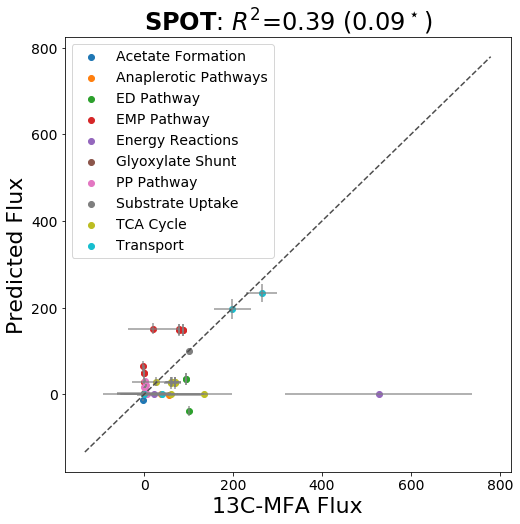

In [11]:
flux_prediction_scatterplot(glucose_fluxes, substrate='glucose', method='SPOT', strain='WT', output_dir=output_dir)

### 5. Generate glucose SPOT flux map

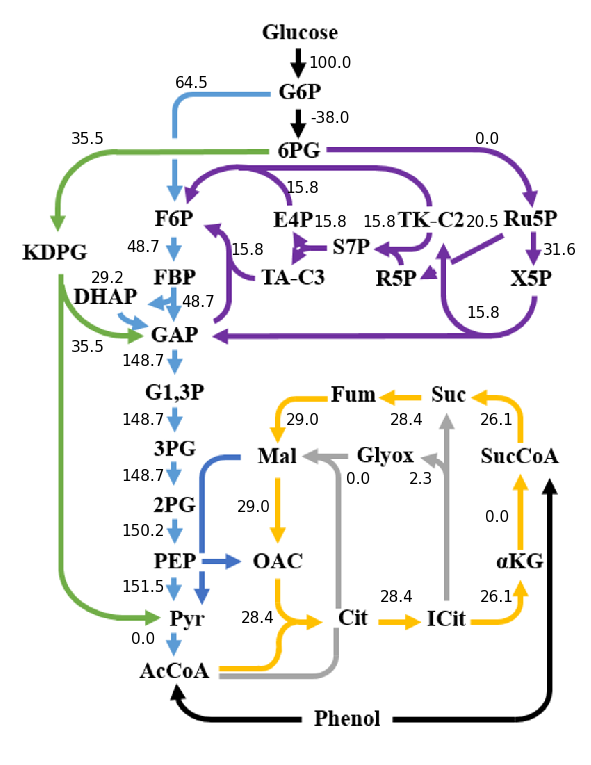

In [12]:
generate_flux_map(glucose_fluxes, 'SPOT WT Flux', substrate='glucose', method='SPOT', strain="WT", output_dir=output_dir)

### 6. Add SPOT glucose data to growth parameters data

Load experimental growth parameters from Notebook E

In [13]:
spot_growth_parameters = growth_parameters.copy()
spot_growth_parameters

,growth rate,yield coefficient,substrate consumption rate,growth rate std dev,yield coefficient std dev,substrate consumption rate std dev
WT-P,0.065488,0.048868,1.352072,0.001345,0.004836,0.122279
PVHG-P,0.080331,0.040848,1.967485,0.002672,0.001757,0.021785
WT-G,0.260195,0.072789,3.582471,0.004749,0.004117,0.141675


Calculate SPOT glucose growth parameters

In [14]:
# only use the first time point for SPOT analysis
relevant_trials = [
    'glucose_spot_t1_1', 
    'glucose_spot_t1_2', 
    'glucose_spot_t1_3',
#     'glucose_spot_t2_1', 
#     'glucose_spot_t2_2', 
#     'glucose_spot_t2_3'
]

# get experimental uptake rate from dataframe
experimental_uptake_rate = spot_growth_parameters.loc['WT-G', 'substrate consumption rate']

# isolate the row with the growth fluxes
growth_flux_row = all_trials_glucose_fluxes[all_trials_glucose_fluxes.Pathway == 'Biomass Equation']

# make a list of the relevant growth rates
growth_fluxes = [growth_flux_row[trial].values[0] for trial in relevant_trials]

# calculate scale factor
scale_factor = -1 * experimental_uptake_rate / normalized_uptake_rate

# calculate growth rat with growth flux and scale factor
growth_rates = [scale_factor * growth_flux for growth_flux in growth_fluxes]

# calculate the average and standard deviations of growth rates
spot_growth_rate = sum(growth_rates) / len(growth_rates)
spot_growth_rate_std = np.std(growth_rates)

Add SPOT glucose data to growth rate data

In [15]:
spot_growth_parameters['SPOT growth rate'] = [np.nan, np.nan, spot_growth_rate]
spot_growth_parameters['SPOT growth std'] = [np.nan, np.nan, spot_growth_rate_std]
spot_growth_parameters

,growth rate,yield coefficient,substrate consumption rate,growth rate std dev,yield coefficient std dev,substrate consumption rate std dev,SPOT growth rate,SPOT growth std
WT-P,0.065488,0.048868,1.352072,0.001345,0.004836,0.122279,NaN,NaN
PVHG-P,0.080331,0.040848,1.967485,0.002672,0.001757,0.021785,NaN,NaN
WT-G,0.260195,0.072789,3.582471,0.004749,0.004117,0.141675,0.0,0.0


Save SPOT growth rates

In [16]:
spot_growth_parameters.to_csv('../data/growth_parameters/spot_growth_parameters.csv', index=True, header=True)